In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            187           9         175           1           3         175
Swap:            11           0          11


In [4]:
!nvidia-smi

Tue Dec  7 06:05:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   42C    P0    78W / 300W |  15660MiB / 16160MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [5]:
import os
from datetime import datetime; now = datetime.now

analysis_name = 'CVAE_'+str(now())
save_dir = os.path.join('../Assets/tf_weights',analysis_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
print(analysis_name)

CVAE_2021-12-07 06:05:24.151557


In [6]:
# CHECK GPU
import nvidia_smi
try:
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

    print("Total memory:", (info.total/1024/1024/1024))
    print("Free memory:", (info.free/1024/1024/1024))
    print("Used memory:", (info.used/1024/1024/1024))

    nvidia_smi.nvmlShutdown()
except:
    pass

Total memory: 15.78173828125
Free memory: 0.48828125
Used memory: 15.29345703125


In [7]:
## SET UP

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from functools import partial
from tqdm import tqdm
from umap import UMAP
tqdm = partial(tqdm, position=0, leave=True) 

In [9]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [10]:
df = pd.read_csv('../Data/ABIDE_df3.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
df = df.sort_values(by='bids_folder')
print(len(df))
df.head()

1048


,Unnamed: 0,participant_id,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,bids_folder,site,funcFile
460,460,50642,1,1.0,33.0,1,R,NaN,103.0,98.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050642,1,CMU_a_0050642_func_preproc.nii.gz
464,464,50646,1,1.0,21.0,1,R,NaN,108.0,100.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050646,1,CMU_a_0050646_func_preproc.nii.gz
465,465,50647,1,1.0,27.0,1,R,NaN,104.0,97.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050647,1,CMU_a_0050647_func_preproc.nii.gz
467,467,50649,1,1.0,22.0,1,R,NaN,127.0,121.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050649,1,CMU_a_0050649_func_preproc.nii.gz
471,471,50653,1,1.0,30.0,1,R,NaN,134.0,131.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050653,1,CMU_a_0050653_func_preproc.nii.gz


### DATA

In [11]:
data_dir = '../Assets/glasser2016_cmats/filt_noglobal/cmat/'

In [12]:
cmats = np.array([np.load(data_dir+str(val)+'.npy') for val in df['participant_id'].values])
cmats.shape

(1048, 360, 360)

In [13]:
rlbls = pd.read_csv('../Data/GlasserAtlas/glasser360NodeNames.txt',header=None)
rlbls = rlbls[0].to_list()
rlbls = np.array(rlbls)
drop_rois = np.array(['Left_OFC', 'Right_TGv', 'Right_OFC', 'Left_TGv', 'Right_s32',
       'Left_s32', 'Left_pOFC', 'Right_25', 'Left_25', 'Right_LO2',
       'Right_TE1m', 'Right_pOFC', 'Left_10pp', 'Right_PIT', 'Right_13l',
       'Left_LO2', 'Left_PIT', 'Left_7AL', 'Right_PeEc', 'Right_TE2a',
       'Left_TE2a', 'Right_10pp', 'Right_10v', 'Right_47m'])

In [14]:
# Slice ROIs
rslice = np.array([rlbl not in drop_rois for rlbl in rlbls])
print(rslice.sum())

cmats = np.array([cmats[i,:,:][rslice,:][:,rslice] for i in range(cmats.shape[0])])
print(cmats.shape)

336
(1048, 336, 336)


In [15]:
# Drop subjects with NaNs
no_nans = np.isnan(cmats).sum(-1).sum(-1)==0
cmats = cmats[no_nans,:,:]
df = df.iloc[no_nans]

In [16]:
# Normalize to 0-1
cmats = (cmats+1)/2

In [17]:
(cmats.min(),cmats.max())

(0.033334957297894874, 1.0)

In [18]:
%%time
## Reliability data


# Load list of bad ROIs
bad_rois = pd.read_csv('../Data/GlasserAtlas/bad_rois.csv')
bad_rois.head()

# Load Rel data
rel_data = np.load('../Assets/glasser2016_cmats/filt_noglobal/rel-cmats.npz')['rel_cmats']
patients = df['DX_GROUP'].values==1 
rel_asd = rel_data[no_nans,:,:,:][patients,:,:,:] #only asd subjects
del rel_data

rel_rlbls = rlbls.copy() 
v = np.array([rel_rlbl not in bad_rois['rlbl'].values[0:12] for rel_rlbl in rel_rlbls]) #initia slice to 348
rel_rlbls = rel_rlbls[v]

v = np.array([rel_rlbl not in bad_rois['rlbl'].values[0:24] for rel_rlbl in rel_rlbls]) # second slice to 336
rel_rlbls = rel_rlbls[v]

rel_asd = rel_asd[:,v,:,:][:,:,v,:]
rel_asd1 = rel_asd[:,:,:,0] # first half 
rel_asd2 = rel_asd[:,:,:,1] # second half 

print(rel_rlbls.shape)

(336,)
CPU times: user 11.4 s, sys: 1.4 s, total: 12.8 s
Wall time: 12.8 s


## END OF DATA

In [19]:
%%time
from importlib import reload
import helper_funcs;reload(helper_funcs);from helper_funcs import *
del helper_funcs
import make_models;reload(make_models);from make_models import *
del make_models

from IPython import display
import sys
from sklearn.decomposition import PCA
import seaborn as sns

import tensorflow as tf
reload(tf)

CPU times: user 44.9 ms, sys: 17 ms, total: 61.8 ms
Wall time: 224 ms


<module 'tensorflow' from '/data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/__init__.py'>

In [20]:
cmats.shape

(1042, 336, 336)

In [21]:
class cvae_data_loader():
    ''' this is the info'''
    def __init__(self,data,df,batch_size=32):
        self.n = len(df)
        self.data = data
        self.epoch = -1
        self.batch_size = batch_size
        self.df = df
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.asd_idxs),len(self.td_idxs)))/self.batch_size))
        
    def new_epoch(self):
        
        self.asd_idxs = np.nonzero((self.df['DX_GROUP'].values==1))[0]
        self.td_idxs = np.nonzero((self.df['DX_GROUP'].values==2))[0]
        
        self.asd_idxs = np.random.permutation(self.asd_idxs)
        self.td_idxs = np.random.permutation(self.td_idxs)
        
        self.epoch += 1
        self.b = 0
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        self.batch_asd_idx = self.asd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        
        self.batch_asd = self.data[self.batch_asd_idx,:,:]
        self.batch_td = self.data[self.batch_td_idx,:,:]

#         self.batch_asd = np.array([np.load(os.path.join(self.data_dir,val+'.npy')) for val in self.df['bids_folder'].values[self.batch_asd_idx]])
#         self.batch_td = np.array([np.load(os.path.join(self.data_dir,val+'.npy')) for val in self.df['bids_folder'].values[self.batch_td_idx]])
        
        self.batch_df = self.df.iloc[np.hstack((self.batch_asd_idx,self.batch_td_idx)),:]
        
    
        return self.batch_asd,self.batch_td,self.batch_df

In [22]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [23]:
# PADDING
#pad2d = tf.keras.layers.ZeroPadding2D(padding=((6,7),(6,7))) #If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))

In [24]:
data_loader = cvae_data_loader(data=cmats, df=df, batch_size=32)
batch_asd,batch_td,batch_df = data_loader.get_batch()

In [25]:
(batch_asd.min(),batch_asd.max())

(0.13419451351970918, 1.0)

In [26]:
data_size = np.hstack((len(df),batch_asd.shape[1:]))
data_size

array([1042,  336,  336])

In [27]:
#patients = df['DX_GROUP'].values==1

In [28]:
# RSA


#cdata = np.array([np.load(os.path.join(data_dir,sub+'.npy')) for sub in df['bids_folder'].values[patients]])
#cdata_pad = pad2d(cdata[:,:,:,np.newaxis]).numpy()[:,:,:,:]

def get_batch_RSA():
    
    patients = ~np.isnan(df['ADOS_TOTAL'].values) * (df['DX_GROUP'].values==1) * ~np.isnan(df['FIQ'].values)
    cdata = cmats[patients,:,:]
    cdata_pad = cdata
    #cdata_pad[patients,:,:]

    Z = z_encoder.predict(cdata_pad)
    S = s_encoder.predict(cdata_pad)

    rdm_z = make_RDM(Z[2])
    rdm_s = make_RDM(S[2])

    rdm_age = make_RDM(df['AGE_AT_SCAN'].values[patients])
    rdm_sex = make_RDM(df['SEX'].values[patients],data_scale='ordinal')
    rdm_fiq = make_RDM(df['FIQ'].values[patients])
    rdm_dsm = make_RDM(df['DSM_IV_TR'].values[patients],data_scale='ordinal')
    rdm_site = make_RDM(df['site'].values[patients],data_scale='ordinal')
    rdm_adosTotal = make_RDM(df['ADOS_TOTAL'].values[patients])
    
    
    batch_rsas_s = dict()
    batch_rsas_z = dict()
    
    
    batch_rsas_s['Site'] = fit_rsa(rdm_s,rdm_site)
    batch_rsas_s['Age'] = fit_rsa(rdm_s,rdm_age)
    batch_rsas_s['Sex'] = fit_rsa(rdm_s,rdm_sex)
    batch_rsas_s['DSM'] = fit_rsa(rdm_s,rdm_dsm)
    batch_rsas_s['ADOS'] = fit_rsa(rdm_s,rdm_adosTotal)
    batch_rsas_s['FIQ'] = fit_rsa(rdm_s,rdm_fiq)

    batch_rsas_z['Site'] = fit_rsa(rdm_z,rdm_site)
    batch_rsas_z['Age'] = fit_rsa(rdm_z,rdm_age)
    batch_rsas_z['Sex'] = fit_rsa(rdm_z,rdm_sex)
    batch_rsas_z['DSM'] = fit_rsa(rdm_z,rdm_dsm)
    batch_rsas_z['ADOS'] = fit_rsa(rdm_z,rdm_adosTotal)
    batch_rsas_z['FIQ'] = fit_rsa(rdm_z,rdm_fiq)
    
    batch_rsas = dict()
    batch_rsas['batch_rsas_z'] = batch_rsas_z
    batch_rsas['batch_rsas_s'] = batch_rsas_s
    
    return batch_rsas

In [29]:
def calc_rel(mat1,mat2):
    
    from scipy.spatial.distance import pdist,squareform

    #mat1 = S_rel1
    #mat2 = S_rel2

    D = squareform(pdist(np.vstack([mat1,mat2])))
    first_second_dist = D[0:mat1.shape[0],:][:,mat1.shape[0]::]

    ranks = []
    for s in range(first_second_dist.shape[0]):
        vec = first_second_dist[s,:]
        within = vec[s]
        across = vec[np.arange(len(vec))!=s]
        rank = (across < within).sum()+1
        ranks.append(rank)

    ranks = np.array(ranks)
    
#     print(np.median(ranks))
#     print((ranks==1).mean())
    
    return ranks

In [30]:
def cvae_dashboard(red='PCA'):        
    #prediction = cvae.predict(patient_batch)    
    predictions = cvae.predict([patient_batch,control_batch])
    sigma = (np.e ** z_encoder.predict(patient_batch)[1]).mean()
    sigmas.append(sigma)

    
    ss = 6;ff=57
    
    mu = z_encoder.predict(patient_batch)[0]
    mus.append(np.mean([mu[:,0].std() for i in range(mu.shape[1])]))

    prediction = predictions[0]

    cmat_actual = np.corrcoef(np.vstack((patient_batch[:,ss:ff,ss:ff].reshape(patient_batch.shape[0],-1),control_batch[:,ss:ff,ss:ff].reshape(control_batch.shape[0],-1))))
    cmat_pred = np.corrcoef(np.vstack((predictions[0][:,ss:ff,ss:ff,:].reshape(predictions[0].shape[0],-1),predictions[1][:,ss:ff,ss:ff,:].reshape(predictions[1].shape[0],-1))))
    c_sim.append(np.corrcoef(get_triu(cmat_pred),get_triu(cmat_actual))[0,1])


    ### PROGRESS PLOTTING
    display.clear_output(wait=True);
    display.display(plt.gcf());
    #Organise figure
    ncols = 4;nrows=7
    if np.mod(i,5)==0:
        plt.close()
    plt.subplots(nrows,ncols,figsize=(15,15)); # MAKE THE FIGURE


    ##### SUBPLOT 1 & 2 ##### 

    plt.subplot(nrows,ncols/2,1) # PLOT LOSS
    xs = np.arange(len(loss))+1
    m,b = np.polyfit(xs,loss,deg=1)
    plt.plot(loss)
    plt.plot(xs, m*xs + b)
    plt.title(f'Epoch {data_loader.epoch} batch {data_loader.b}/{data_loader.n_batches} | Loss {loss[-1]:.2f}, beta: {m:.4f}')

    ##### SUBPLOT 3 ##### 
    plt.subplot(nrows,ncols,3) # PLOT LOSS LAST 50
    hb = 50
    if len(loss)>hb:
        plot_loss = loss[-hb::]
        xs = np.arange(len(plot_loss))
        m,b = np.polyfit(xs,plot_loss,deg=1)
        plt.plot(plot_loss)
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'Loss last {hb} it, beta {m:.4f}')

    ##### SUBPLOT 4 ##### 
    plt.subplot(nrows,ncols,4)
    plt.hist(prediction[0,ss:ff,ss:ff,0].flatten(),alpha=.5)
    plt.hist(patient_batch[0,ss:ff,ss:ff].flatten(),alpha=.5)
    plt.legend(['predicted','actual'])
    plt.title('in/out histograms')

    ##### SUBPLOT 5 ##### 
    plt.subplot(nrows,ncols,5) #RSA over time
    plt.plot(c_sim)
    plt.title(f'in/out RSA: {c_sim[-1].round(2)}')

    if len(c_sim)>5: # PLOT LS LINE
        xs = np.arange(len(c_sim))+1
        m,b = np.polyfit(xs,c_sim,deg=1)
        plt.plot(xs, m*xs + b)
        plt.title(f'in/out RSA: {c_sim[-1].round(2)}, b={m:.4f}')


    ##### SUBPLOT 6 ##### 
    plt.subplot(nrows,ncols,6)
    if len(c_sim)>hb:
        #plot_loss = loss[-hb::]
        xs = np.arange(len(c_sim[-hb::]))
        m,b = np.polyfit(xs,c_sim[-hb::],deg=1)
        plt.plot(c_sim[-hb::])
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'in/outRSA last {hb} it, b={m:.4f}')
        
        
        
    batch_rsas = get_batch_RSA()
    batch_rsas_z = batch_rsas['batch_rsas_z']
    batch_rsas_s = batch_rsas['batch_rsas_s']
    
    # ##### SUBPLOT 7 ##### 
    plt.subplot(nrows,ncols,7)    
    xlbls = list(batch_rsas_z.keys())
    xs = np.arange(len(xlbls))
    ys = np.array([batch_rsas_z[key] for key in xlbls])
    plt.bar(xs,ys)
    plt.xticks(xs,labels=xlbls);
    plt.title('Z RSA')
    
    # ##### SUBPLOT 8 ##### 
    plt.subplot(nrows,ncols,8)    
    xlbls = list(batch_rsas_s.keys())
    xs = np.arange(len(xlbls))
    ys = np.array([batch_rsas_s[key] for key in xlbls])
    plt.bar(xs,ys)
    plt.xticks(xs,labels=xlbls);
    plt.title('S RSA')

    ##### SUBPLOT 9 ##### 
    plt.subplot(nrows,ncols,9)
    plt.plot(sigmas)
    plt.title(f'sigmas | {sigmas[-1]:.4f}')


    ##### SUBPLOT 10 ##### 
    plt.subplot(nrows,ncols,10)
    plt.plot(mus)
    plt.title(f'Mu variance {mus[-1]:.4f}')


    ##### SUBPLOT 11 ##### 
    plt.subplot(nrows,ncols,11)
    sns.heatmap(cmat_actual,xticklabels=[],yticklabels=[])
    plt.title('input RSA')

    ##### SUBPLOT 12 ##### 
    plt.subplot(nrows,ncols,12)
    sns.heatmap(cmat_pred,xticklabels=[],yticklabels=[])
    plt.title('output RSA')

    # #############################################
    # ###################Reconstructions###########
    # #############################################

    ##### SUBPLOT 13 #####     
    rand_sub = np.random.randint(low=0,high=patient_batch.shape[0])

    plt.subplot(nrows,ncols,13)
    sns.heatmap(patient_batch[rand_sub,ss:ff,ss:ff])
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 14 #####     
    plt.subplot(nrows,ncols,14)
    sns.heatmap(prediction[rand_sub,ss:ff,ss:ff,0])
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    # ##### SUBPLOT 15 #####     
    plt.subplot(nrows,ncols,15)
    sns.heatmap(abs(patient_batch[rand_sub,ss:ff,ss:ff]-prediction[rand_sub,ss:ff,ss:ff,0]))
    plt.xticks([]);plt.yticks([]);plt.title('difference')
    
    
    # ##### SUBPLOT 16 #####                                             


    # ##### SUBPLOT 17 #####                             
    plt.subplot(nrows,ncols,17)
    Z_rel1 = z_encoder.predict(rel_asd1)[0]
    Z_rel2 = z_encoder.predict(rel_asd2)[0]
    z_ranks.append(np.median(calc_rel(Z_rel1,Z_rel2)))
    plt.plot(z_ranks)
    plt.title(f'Z rel\nmed rank = {int(np.median(z_ranks))}, rank1 acc = {(np.array(z_ranks)==1).mean():.4f}')

    # ##### SUBPLOT 18 #####     
    plt.subplot(nrows,ncols,18)
    S_rel1 = s_encoder.predict(rel_asd1)[0]
    S_rel2 = s_encoder.predict(rel_asd2)[0]
    s_ranks.append(np.median(calc_rel(S_rel1,S_rel2)))
    plt.plot(s_ranks)
    plt.title(f'S rel\nmed rank = {int(np.median(s_ranks))}, rank1 acc = {(np.array(s_ranks)==1).mean():.4f}')
    
    
    # ##### SUBPLOT 18 #####                                             
    # ##### SUBPLOT 19 #####     
    # plt.subplot(nrows,ncols,19)
    # plt.imshow(patient_batch[rand_sub,:,:,16,rand_map])
    # plt.xticks([]);plt.yticks([]);plt.title('actual')
    # ##### SUBPLOT 20 #####     
    # plt.subplot(nrows,ncols,20)
    # plt.imshow(prediction[rand_sub,:,:,16,rand_map])
    # plt.xticks([]);plt.yticks([]);plt.title('predicted')


    # #############################################
    # ################### LOSSES ##################
    # #############################################


    predictions = cvae.predict([patient_batch,control_batch])
    input_shape = data_size[1:]
    reconstruction_loss = tf.keras.losses.mse(K.flatten(patient_batch[:,ss:ff,ss:ff]), K.flatten(predictions[0][:,ss:ff,ss:ff,0])) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(control_batch[:,ss:ff,ss:ff]), K.flatten(predictions[1][:,ss:ff,ss:ff,0])) 
    reconstruction_loss *= input_shape[0] * input_shape[1]


    tg_z_mean, tg_z_log_var, tg_z = z_encoder.predict(patient_batch)
    tg_s_mean, tg_s_log_var, tg_s = s_encoder.predict(patient_batch)
    bg_z_mean, bg_z_log_var, bg_z = z_encoder.predict(control_batch)

    kl_loss1 = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss2 = 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss3 = 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)

    kl_loss1 = tf.keras.backend.sum(kl_loss1, axis=-1)
    kl_loss2 = tf.keras.backend.sum(kl_loss2, axis=-1)
    kl_loss3 = tf.keras.backend.sum(kl_loss3, axis=-1)
    kl_loss = kl_loss1+kl_loss2+kl_loss3
    kl_loss *= -0.5


    discriminator = Dense(1, activation='sigmoid')
    z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
    z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
    s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
    s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

    q_bar = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z2], axis=1),
      tf.keras.layers.concatenate([s2, z1], axis=1)],
      axis=0)

    q = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z1], axis=1),
      tf.keras.layers.concatenate([s2, z2], axis=1)],
      axis=0)

    q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
    q_score = (discriminator(q)+.1) *.85 
    tc_loss = K.log(q_score / (1 - q_score)) 
    discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    discriminator_loss

    loss_mse.append(reconstruction_loss.numpy())
    loss_kl.append(kl_loss.numpy().mean())
    loss_dc.append(tc_loss.numpy().mean())
    loss_tc.append(discriminator_loss.numpy().mean())


    plt.subplot(nrows,ncols,21) # MSE 
    plt.plot(loss_mse)
    plt.title(f'MSE | {loss_mse[-1]:.4f}')

    plt.subplot(nrows,ncols,22) # KL loss
    plt.plot(loss_kl)
    plt.title(f'KL | {loss_kl[-1]:.4f}')    


    plt.subplot(nrows,ncols,23) # TC     
    plt.plot(loss_tc)
    plt.title(f'Total Correlation loss | {loss_tc[-1]:.4f}')    


    plt.subplot(nrows,ncols,24) # Disc         
    plt.plot(loss_dc)
    plt.title(f'discriminator_loss | {loss_dc[-1]:.4f}')    


    tg_s = s_encoder.predict(patient_batch)
    tg_z = z_encoder.predict(patient_batch)
    bg_z = z_encoder.predict(control_batch)

    plt.subplot(nrows,ncols,25)
    plt.hist(tg_s[2].flatten(),alpha=.5);
    plt.hist(tg_z[2].flatten(),alpha=.5);
    plt.hist(bg_z[2].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Z')


    plt.subplot(nrows,ncols,26)
    plt.hist(tg_s[0].flatten(),alpha=.5);
    plt.hist(tg_z[0].flatten(),alpha=.5);
    plt.hist(bg_z[0].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Mus')


    plt.subplot(nrows,ncols,27)
    plt.hist(tg_s[1].flatten(),alpha=.5);
    plt.hist(tg_z[1].flatten(),alpha=.5);
    plt.hist(bg_z[1].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Sigmas')

    plt.tight_layout()
    plt.show()
    sys.stdout.flush()

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import os
import pandas as pd

def get_fMRI_CVAE_3D(input_shape=(51,51,1),
                     latent_dim=[2,2],
                     beta=1,
                     disentangle=False,
                     gamma=1,
                     bias=True,
                     batch_size = 32,
                     kernel_size = 3,
                     filters = 16,
                     intermediate_dim = 128,
                     nlayers = 2,
                     learning_rate=0.001,
                     opt=None):
    
    
    ndim_bg = latent_dim[0]
    ndim_sl = latent_dim[1]
    
    image_size, _, channels = input_shape

    kernel_regularizer=regularizers.l2(.0001)

    # build encoder model
    tg_inputs = Input(shape=input_shape, name='tg_inputs')
    bg_inputs = Input(shape=input_shape, name='bg_inputs')
    
#     BatchNorm = tf.keras.layers.BatchNormalization(
#     axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
#     beta_initializer='zeros', gamma_initializer='ones',
#     moving_mean_initializer='zeros',
#     moving_variance_initializer='ones', beta_regularizer=None,
#     gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    #kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,stddev=5)
    kernel_initializer = tf.keras.initializers.RandomUniform()

    # generate latent vector Q(z|X)
    
    
    z_h_layer = Dense(intermediate_dim,activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
#    z_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=tf.keras.initializers.random_normal(mean=0.0, stddev=5),bias_initializer=tf.keras.initializers.random_normal(mean=0.0, stddev=5))
    z_mean_layer = Dense(ndim_bg, name='z_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_log_var_layer = Dense(ndim_bg, name='z_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_layer = Lambda(sampling, output_shape=(ndim_bg,), name='z')

    def z_encoder_func(inputs):
        z_h = inputs

        these_filters = filters
        for i in range(nlayers):
            these_filters *= 2
            #print(these_filters)
            z_h = Conv2D(filters=these_filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=2,
                    padding='same',
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer)(z_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(z_h)
        z_h = Flatten()(z_h)
        z_h = z_h_layer(z_h)
        z_mean =  z_mean_layer(z_h)
        #z_mean = BatchNorm(z_mean)
        
        z_log_var =  z_log_var_layer(z_h)
        z = z_layer([z_mean, z_log_var])
        return z_mean, z_log_var, z, shape

    tg_z_mean, tg_z_log_var, tg_z, shape_z = z_encoder_func(tg_inputs)

    # generate latent vector Q(z|X)
    s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
#    s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=tf.keras.initializers.random_normal(mean=0.0, stddev=5),bias_initializer=tf.keras.initializers.random_normal(mean=0.0, stddev=5))
    s_mean_layer = Dense(ndim_sl, name='s_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_log_var_layer = Dense(ndim_sl, name='s_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_layer = Lambda(sampling, output_shape=(ndim_sl,), name='s')

    def s_encoder_func(inputs):
        s_h = inputs
        these_filters = filters
        for i in range(nlayers):
            these_filters *= 2
            s_h = Conv2D(filters=these_filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=2,
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer,
                    padding='same')(s_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(s_h)
        s_h = Flatten()(s_h)
        s_h = s_h_layer(s_h)
        s_mean =  s_mean_layer(s_h)
        #s_mean = BatchNorm(s_mean)
        
        s_log_var =  s_log_var_layer(s_h)        
        s = s_layer([s_mean, s_log_var])
        
        return s_mean, s_log_var, s, shape

    tg_s_mean, tg_s_log_var, tg_s, shape_s = s_encoder_func(tg_inputs)
    bg_z_mean, bg_z_log_var, bg_z, _ = z_encoder_func(bg_inputs) # Aidas and Stefano team hax
    
    
    # instantiate encoder models
    z_encoder = tf.keras.models.Model(tg_inputs, [tg_z_mean, tg_z_log_var, tg_z], name='z_encoder')
    s_encoder = tf.keras.models.Model(tg_inputs, [tg_s_mean, tg_s_log_var, tg_s], name='s_encoder')


    # build decoder model
    latent_inputs = Input(shape=(ndim_bg+ndim_sl,), name='z_sampling')

    x = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(latent_inputs)
    x = Dense(shape_z[1] * shape_z[2] * shape_z[3], activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(x)
    x = Reshape((shape_z[1], shape_z[2], shape_z[3]))(x)

    these_filters = filters*(2**nlayers)/2
    for i in range(nlayers-1):
        x = Conv2DTranspose(filters=these_filters,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=2,
                          use_bias=bias,
                          kernel_regularizer=kernel_regularizer,
                          padding='same')(x)
        these_filters //= 2

    outputs = Conv2DTranspose(filters=channels,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            strides=2,
                            use_bias=bias,
                            kernel_regularizer=kernel_regularizer,
                            name='decoder_output')(x)

    # instantiate decoder model
    cvae_decoder = Model(latent_inputs, outputs, name='decoder')
      # decoder.summary()

    def zeros_like(x):
        return tf.zeros_like(x)

    tg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, tg_s], -1))
    zeros = tf.keras.layers.Lambda(zeros_like)(tg_s)

    bg_outputs = cvae_decoder(tf.keras.layers.concatenate([bg_z, zeros], -1)) # Aidas look into this, is this correct

    cvae = tf.keras.models.Model(inputs=[tg_inputs, bg_inputs], 
                                  outputs=[tg_outputs, bg_outputs],
                                  name='contrastive_vae')

#     cvae_fg = tf.keras.models.Model(inputs=tg_inputs, 
#                                   outputs=fg_outputs, 
#                                   name='contrastive_vae_fg')

    if disentangle:
        discriminator = Dense(1, activation='sigmoid')

        z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
        z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
        s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
        s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

        q_bar = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z2], axis=1),
          tf.keras.layers.concatenate([s2, z1], axis=1)],
          axis=0)

        q = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z1], axis=1),
          tf.keras.layers.concatenate([s2, z2], axis=1)],
          axis=0)

        q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
        q_score = (discriminator(q)+.1) *.85 
        tc_loss = K.log(q_score / (1 - q_score)) 
        discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    else:
        tc_loss = 0
        discriminator_loss = 0


    reconstruction_loss = tf.keras.losses.mse(K.flatten(tg_inputs), K.flatten(tg_outputs)) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(bg_inputs), K.flatten(bg_outputs)) 
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]

    kl_loss1 = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss2 = 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss3 = 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)

    kl_loss1 = tf.keras.backend.sum(kl_loss1, axis=-1)
    kl_loss2 = tf.keras.backend.sum(kl_loss2, axis=-1)
    kl_loss3 = tf.keras.backend.sum(kl_loss3, axis=-1)

    kl_loss = kl_loss1+kl_loss2+kl_loss3
    #kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    cvae_loss = tf.keras.backend.mean(reconstruction_loss + beta*kl_loss + gamma*tc_loss + discriminator_loss)
    cvae.add_loss(cvae_loss)
    
    if type(opt)==type(None):
        #print('optimizer not specified using ADAM, wroom wroom')
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')
        #opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False, name='RMSprop')
        #opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.1, nesterov=False, name='SGD')


    cvae.compile(optimizer=opt,run_eagerly=True)
    
    return cvae, z_encoder, s_encoder, cvae_decoder

In [32]:
print(data_size)

[1042  336  336]


In [33]:
input_shape = (336,336,1)

In [34]:
batch_size = 32
cvae, z_encoder, s_encoder, cvae_decoder = get_fMRI_CVAE_3D(input_shape=input_shape,
                                                             latent_dim=[16,16],
                                                             beta=1,
                                                             gamma=1,
                                                             disentangle=False,
                                                             bias=False,
                                                             batch_size = batch_size,
                                                             kernel_size = 2,
                                                             filters = 4,
                                                             intermediate_dim = 128,
                                                             nlayers = 3,
                                                             learning_rate=0.001,
                                                             opt=None)

num_params = np.sum([np.prod(val.get_shape()) for val in cvae.trainable_weights])
print(f'# params| {num_params:,}')

# params| 21,698,688


In [35]:
z_encoder.summary(line_length=150)

Model: "z_encoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
tg_inputs (InputLayer)                           [(None, 336, 336, 1)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                  (None, 168, 168, 8)              32                tg_inputs[0][0]                                   
______________________________________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                                (None, 84, 84, 16)        

In [36]:
s_encoder.summary(line_length=150)

Model: "s_encoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
tg_inputs (InputLayer)                           [(None, 336, 336, 1)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d_3 (Conv2D)                                (None, 168, 168, 8)              32                tg_inputs[0][0]                                   
______________________________________________________________________________________________________________________________________________________
conv2d_4 (Conv2D)                                (None, 84, 84, 16)        

In [37]:
cvae_decoder.summary(line_length=150)

Model: "decoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
z_sampling (InputLayer)                                            [(None, 32)]                                                0                      
______________________________________________________________________________________________________________________________________________________
dense_2 (Dense)                                                    (None, 128)                                                 4096                   
______________________________________________________________________________________________________________________________________________________
dense_3 (Dense)                                                    (None, 564

In [38]:
# Initialize arrays
loss,all_rsas,sigmas,mus,c_sim = [],[],[],[],[]
loss_mse,loss_kl,loss_dc,loss_tc = [],[],[],[]
s_ranks,z_ranks = [],[]

<Figure size 432x288 with 0 Axes>

<ipython-input-30-c857a819e6bf>:32: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols/2,1) # PLOT LOSS


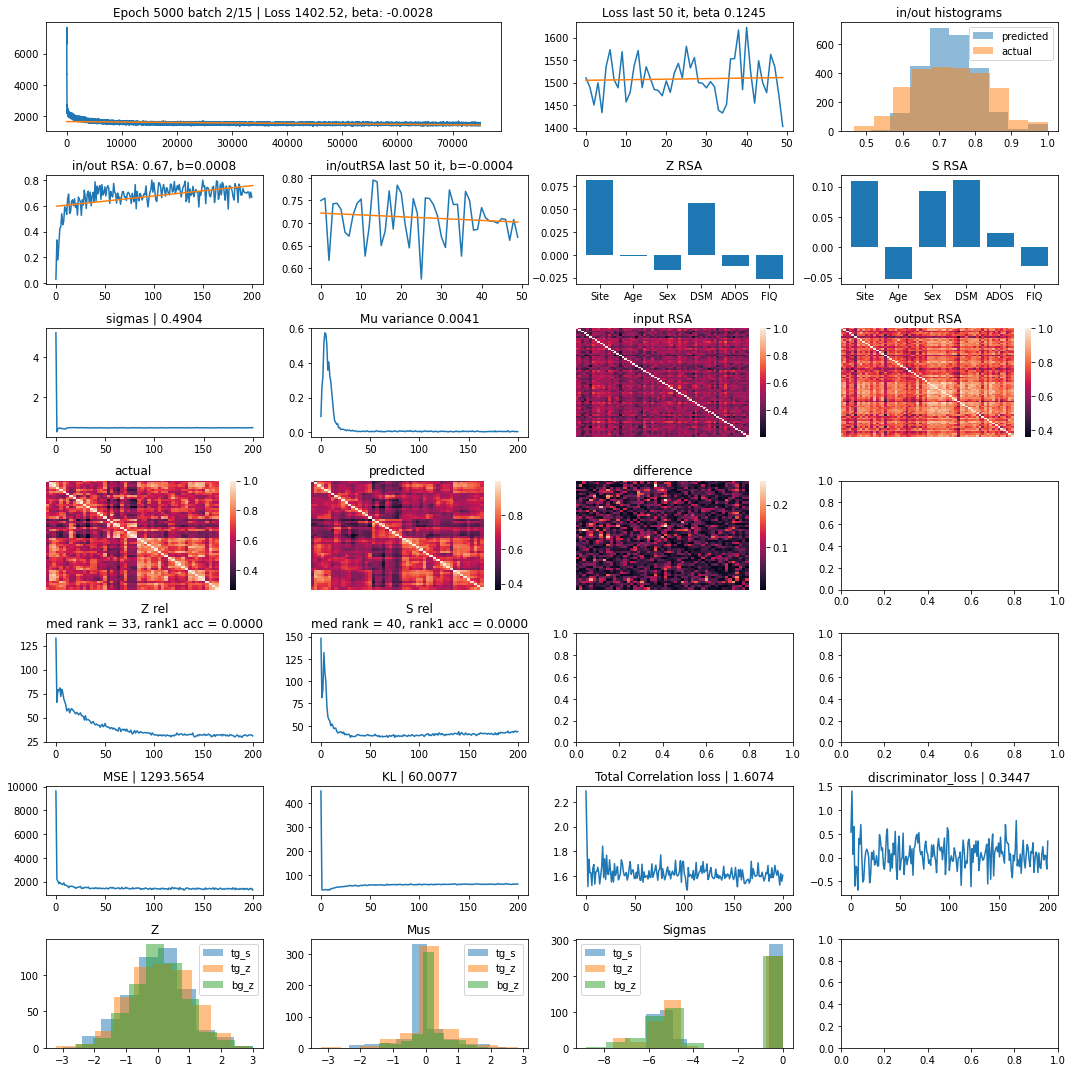

100%|██████████| 5001/5001 [2:01:42<00:00,  1.46s/it]


In [39]:
for epoch in tqdm(range(5001)):
    for i in range(data_loader.n_batches):
        
        patient_batch,control_batch,batch_df = data_loader.get_batch() # Get a batch
        
        hist = cvae.train_on_batch([patient_batch,control_batch]) # pass a batch
        assert not np.isnan(hist),'loss is NaN - you f**cked up'  # check nothing crashed
        loss.append(hist) # keep track of loss
        
        if all((i==0,np.mod(epoch,25)==0)):
            cvae_dashboard() # plot training progress
            cvae.save_weights(os.path.join(save_dir,'cvae_weights')) # SAVE WEIGHTS
            np.save(os.path.join(save_dir,'cvae_loss.npy'),np.array(loss)) # Save loss
            #plt.show()

In [40]:
cvae.summary(line_length=150)

Model: "contrastive_vae"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
tg_inputs (InputLayer)                           [(None, 336, 336, 1)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d_3 (Conv2D)                                (None, 168, 168, 8)              32                tg_inputs[0][0]                                   
______________________________________________________________________________________________________________________________________________________
bg_inputs (InputLayer)                           [(None, 336, 336, 1)